In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Part 1

## Data Acquisition and Preparation

### Dataset

**Daily Land (Experimental; 1880 – 2018)**

This data set is an experimental temperature time series with daily resolution. It contains a summary of the daily land-surface average anomaly results produced by the Berkeley Earth averaging method. Temperatures are in Celsius and reported as anomalies relative to the Jan 1951-Dec 1980 average.

The current dataset presented here is described as: **Berkeley Earth daily TAVG full dataset**

This analysis was run on 26-Jan-2019 13:12:02

Results are based on monthly time series

Estimated Jan 1951-Dec 1980 land-average temperature (C): 8.63 +/- 0.06

The dataset is download from Berkeley Earth, http://berkeleyearth.org/data/

In [56]:
TAVG = pd.read_csv("data/Complete_TAVG_daily.csv")

In [5]:
TAVG

,Date Number,Year,Month,Day,Day of Year,Anomaly
0,1880.001,1880,1,1,1,-0.786
1,1880.004,1880,1,2,2,-0.695
2,1880.007,1880,1,3,3,-0.783
3,1880.010,1880,1,4,4,-0.725
4,1880.012,1880,1,5,5,-0.802
...,...,...,...,...,...,...
50764,2018.988,2018,12,27,361,0.965
50765,2018.990,2018,12,28,362,0.765
50766,2018.993,2018,12,29,363,0.611
50767,2018.996,2018,12,30,364,0.636


### Data Modification

In [6]:
TAVG_df = TAVG.copy()
TAVG_df['date'] = pd.to_datetime(TAVG_df[['Year','Month','Day']])
TAVG_df['Temperature'] = TAVG_df['Anomaly']+8.63
TAVG_df = TAVG_df.dropna()

In [7]:
def drop_irrelevant(df):
    try:
        df = df.drop(columns=['Date Number','Year','Month','Day','Day of Year','Anomaly'])
    except KeyError:
        print("Note: Either the columns were not found or already dropped.")
    return df

### Data Visuallization

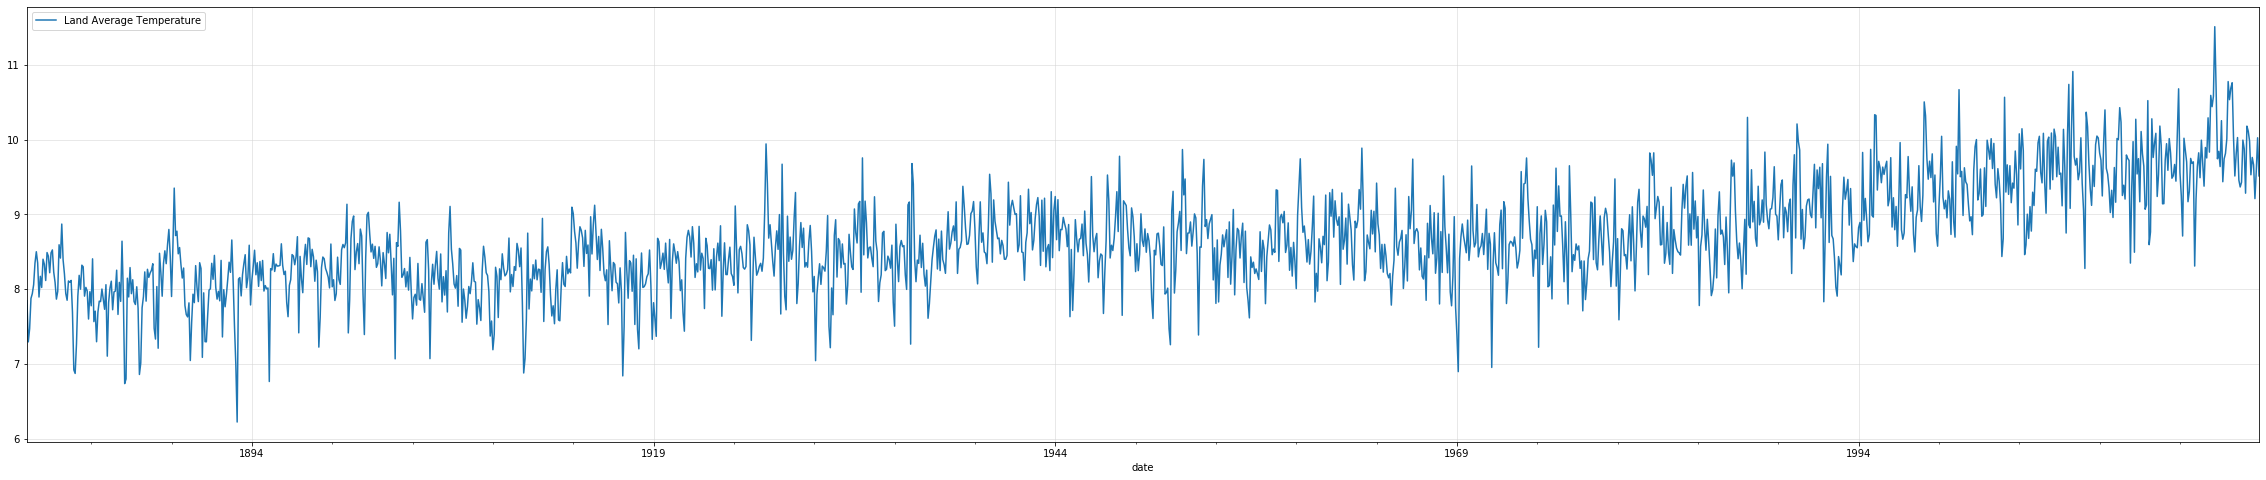

In [8]:
df = TAVG_df.loc[(TAVG_df['Day']==1)].copy()
fig, ax = plt.subplots()
df = df.set_index('date')
df.plot(y='Temperature', label='Land Average Temperature', figsize = (40,8), ax=ax)
ax.grid(color='lightgray', linestyle='-', linewidth=.5)

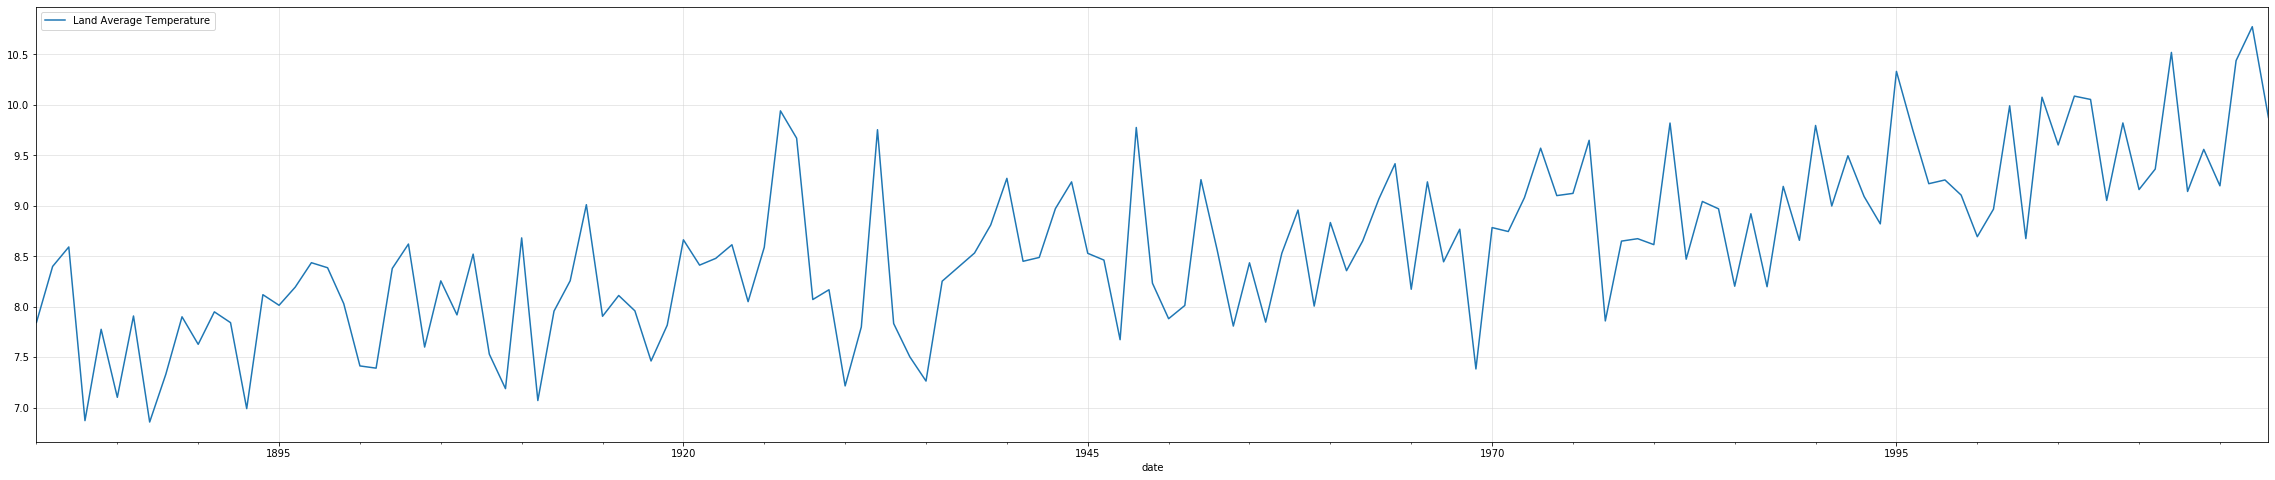

In [9]:
df = TAVG_df.loc[(TAVG_df['Day of Year']==1)].copy()
fig, ax = plt.subplots()
df = df.set_index('date')
df.plot(y='Temperature', label='Land Average Temperature', figsize = (40,8), ax=ax)
ax.grid(color='lightgray', linestyle='-', linewidth=.5)

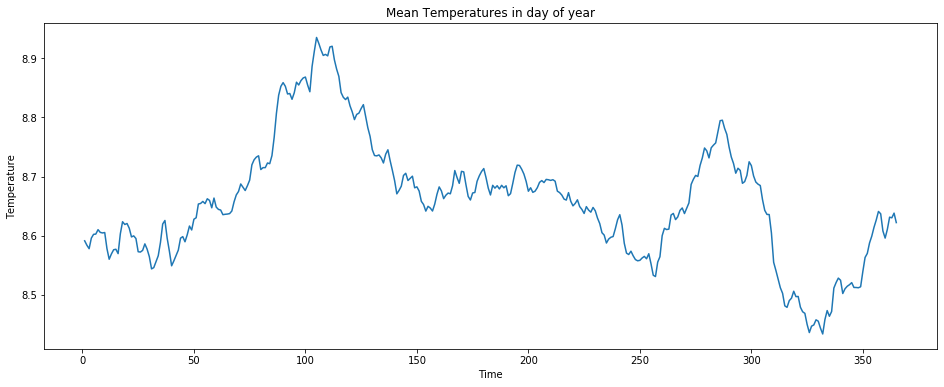

In [10]:
df = TAVG_df.groupby(['Day of Year'])["Temperature"].mean()
plt.figure(figsize = (16, 6))
plt.title('Mean Temperatures in day of year')
plt.xlabel("Time")
plt.ylabel("Temperature")
plt.plot(df)

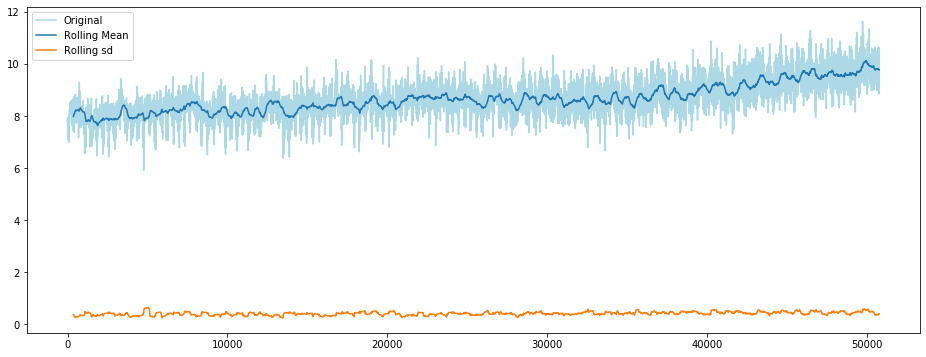

In [11]:
df = TAVG_df.copy()
plt.figure(figsize = (16, 6))
plt.plot(df['Temperature'], color = 'lightblue', label = 'Original')
plt.plot(df['Temperature'].rolling(window = 365, center = False).mean(), label = 'Rolling Mean')
plt.plot(df['Temperature'].rolling(window = 365, center = False).std(), label = 'Rolling sd')
plt.legend()

**Findings:**

- The overall trend of temperature is rising.


- There is an obviously "seasonality". ("Eg: peak temperatures around a time of a yea) and a decreasing "Trend".

Let's Checck that with a quick decomposition into Trend, seasonality and residuals.

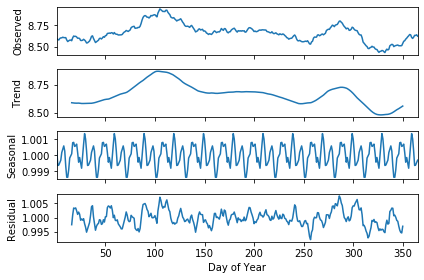

In [12]:
df = TAVG_df.groupby(['Day of Year'])["Temperature"].mean()
res = sm.tsa.seasonal_decompose(df, freq = 30, model = "multiplic ative")
fig = res.plot()

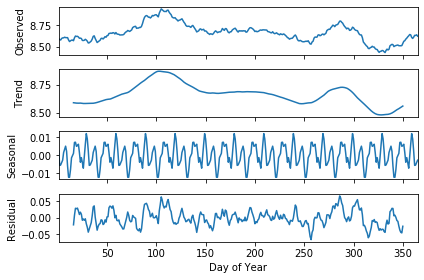

In [13]:
df = TAVG_df.groupby(['Day of Year'])["Temperature"].mean()
res = sm.tsa.seasonal_decompose(df, freq = 30, model = "additive")
fig = res.plot()

## Stationarity

<img src='data/stationarity.png' align='left' style=' height:150 px'/>

Stationarity refers to time-invariance of a series. 

When a time series is stationary, it can be easier to model. Statistical modeling methods assume or require the time series to be stationary.

### Stationary Processes

An important assumption in statistical estimation theory is that, for sample statistics to be reliable, the population does not undergo any fundamental or systemic shifts over the individuals in the sample or over the time during which the data has been collected. This assumption ensures that sample statistics do not alter and will hold for entities that are outside the sample used for their estimation.

This assumption also applies to time series analysis so that mean, variance and auto-correlation estimated from the simple can be used as a reasonable estimate for future occurrences. In time series analysis, this assumption is known as stationarity, which requires that the internal structures of the series do not change over time. Therefore, stationarity requires mean, variance, and autocorrelation to be invariant with respect to the actual time of observation. Another way of understanding stationarity is that the series has constant mean and constant variance without any predictable and repetitive patterns.

However, most real-life time series are not stationary. Non-stationarity mostly arises due to the presence of trend and seasonality that affects the mean, variance, and autocorrelation at different points in time. In general, a time series with no predictable patterns in the long run (without considering exogenous factors as explanatory variables of course!) is stationary.

In [14]:
#raw data
# df = TAVG_df.loc[(TAVG_df['Day']==1)].copy()
df = TAVG_df.groupby([TAVG_df['Year'],TAVG_df['Month']])['Temperature'].mean().to_frame().copy()
#raw data - rolling mean
df_mean = df.copy()
df_mean['mean_Temperature'] = df_mean.Temperature.rolling(window=12).mean()
#raw data - rolling std
df_std = df.copy()
df_std['std_Temperature'] = df_std.Temperature.rolling(window=12).std()
#de-trended data - rolling mean (annual)
df_z = df.copy()
df_z['z_Temperature'] = (df_z['Temperature'] - df_z.Temperature.rolling(window=12).mean())/df_z.Temperature.rolling(window=12).std()
#12 lag differenced de-trended data - rolling mean (annual)
df_zp = df.copy()
df_zp['z_Temperature'] = (df_zp['Temperature'] - df_zp.Temperature.rolling(window=12).mean())/df_zp.Temperature.rolling(window=12).std()
df_zp['zp_Temperature'] = df_zp['z_Temperature'] - df_zp['z_Temperature'].shift(12)

### ADF output

An crucial step in time series analysis is statistically verifying stationarity and destationarizing a non-stationary time series through special mathematical operations. Augmented Dickey-Fuller (ADF) is the method usually used for stationarity detection.

**raw data**

In [15]:
from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries):
    #Perform Dickey-Fuller test
    print('Result of Dickey-Fuller Test:')
    dftest = adfuller(timeseries,  autolag = 'AIC')
    print("Test statistic = {:.3f}".format(dftest[0]))
    print("P-value = {:.3f}".format(dftest[1]))
    print("Critical values:")
    for k, v in dftest[4].items():
        print("\t{}: {} - The data {} stationary with {}% confidence".format(k, v, "is not" if v<dftest[0] else "is", 100-int(k[:-1])))

In [16]:
df = TAVG_df.groupby([TAVG_df['Year'],TAVG_df['Month']])['Temperature'].mean().to_frame().copy()
adf_test(df.Temperature)

Result of Dickey-Fuller Test:
Test statistic = -0.955
P-value = 0.769
Critical values:
	1%: -3.4343363335985666 - The data is not stationary with 99% confidence
	5%: -2.8633007375690576 - The data is not stationary with 95% confidence
	10%: -2.5677073765535114 - The data is not stationary with 90% confidence


**raw data - rolling mean (annual)**

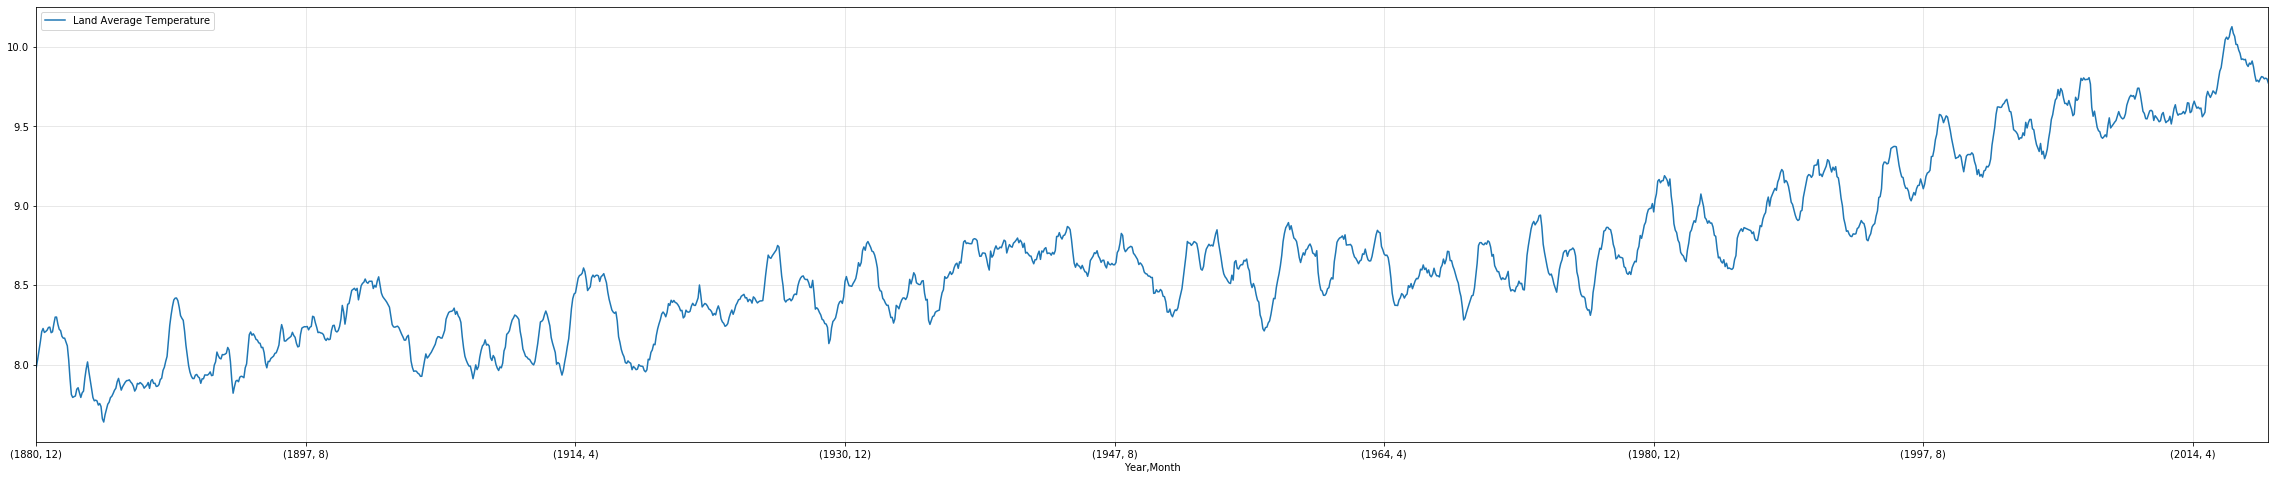

In [17]:
df = df_mean.dropna()
fig, ax = plt.subplots()
df.plot(y='mean_Temperature', label='Land Average Temperature', figsize = (40,8), ax=ax)
ax.grid(color='lightgray', linestyle='-', linewidth=.5)

In [18]:
adf_test(df_mean.mean_Temperature.dropna())

Result of Dickey-Fuller Test:
Test statistic = -0.492
P-value = 0.894
Critical values:
	1%: -3.4343657092003164 - The data is not stationary with 99% confidence
	5%: -2.8633137038658023 - The data is not stationary with 95% confidence
	10%: -2.567714280966453 - The data is not stationary with 90% confidence


**raw data - rolling std (x10)**

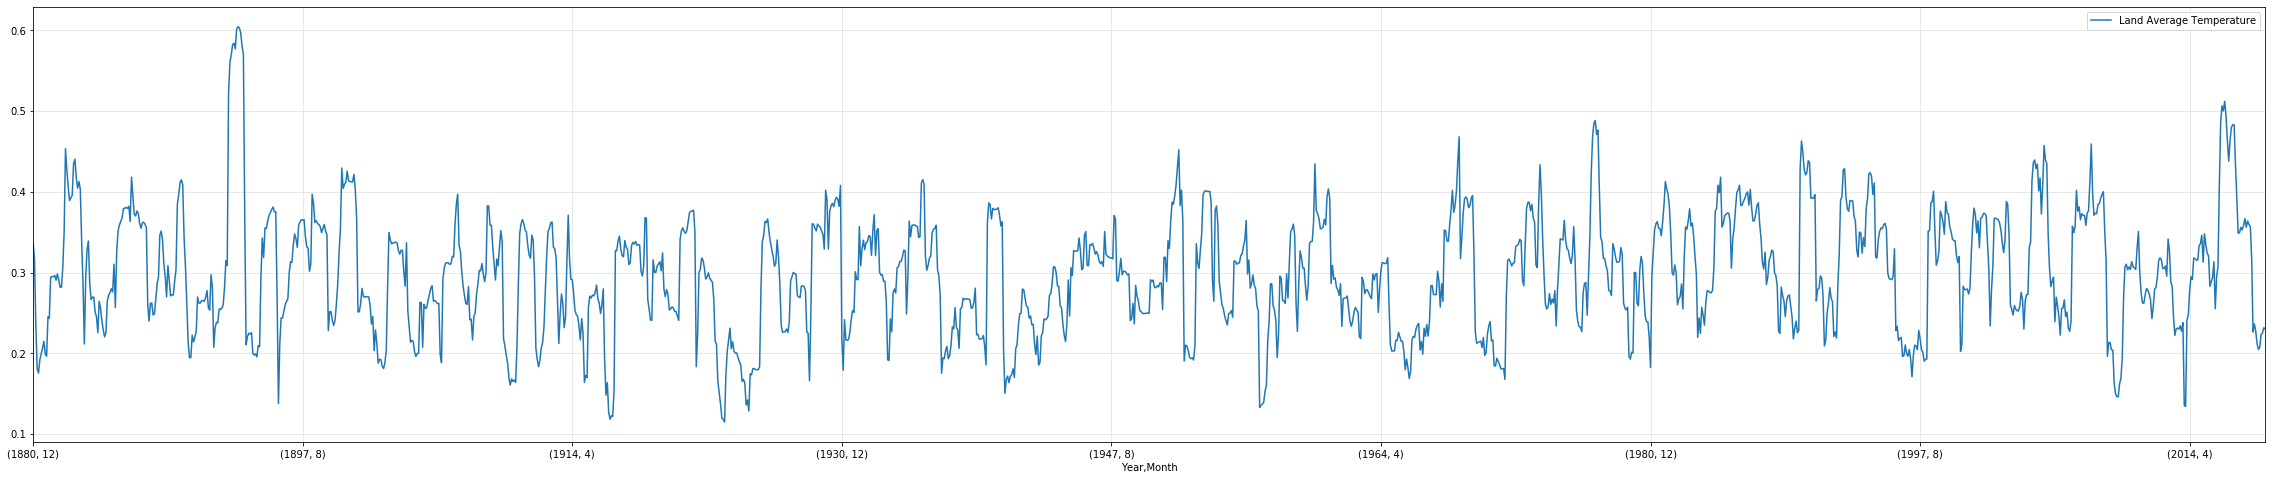

In [19]:
df = df_std.dropna()
# df = df.loc[(df['Year']>=2000)]
fig, ax = plt.subplots()
# df = df.set_index('date')
df.plot(y='std_Temperature', label='Land Average Temperature', figsize = (40,8), ax=ax)
ax.grid(color='lightgray', linestyle='-', linewidth=.5)

In [20]:
adf_test(df_std.std_Temperature.dropna())

Result of Dickey-Fuller Test:
Test statistic = -7.521
P-value = 0.000
Critical values:
	1%: -3.434363244707632 - The data is stationary with 99% confidence
	5%: -2.8633126160514863 - The data is stationary with 95% confidence
	10%: -2.567713701716287 - The data is stationary with 90% confidence


**de-trended data - rolling mean (annual)**

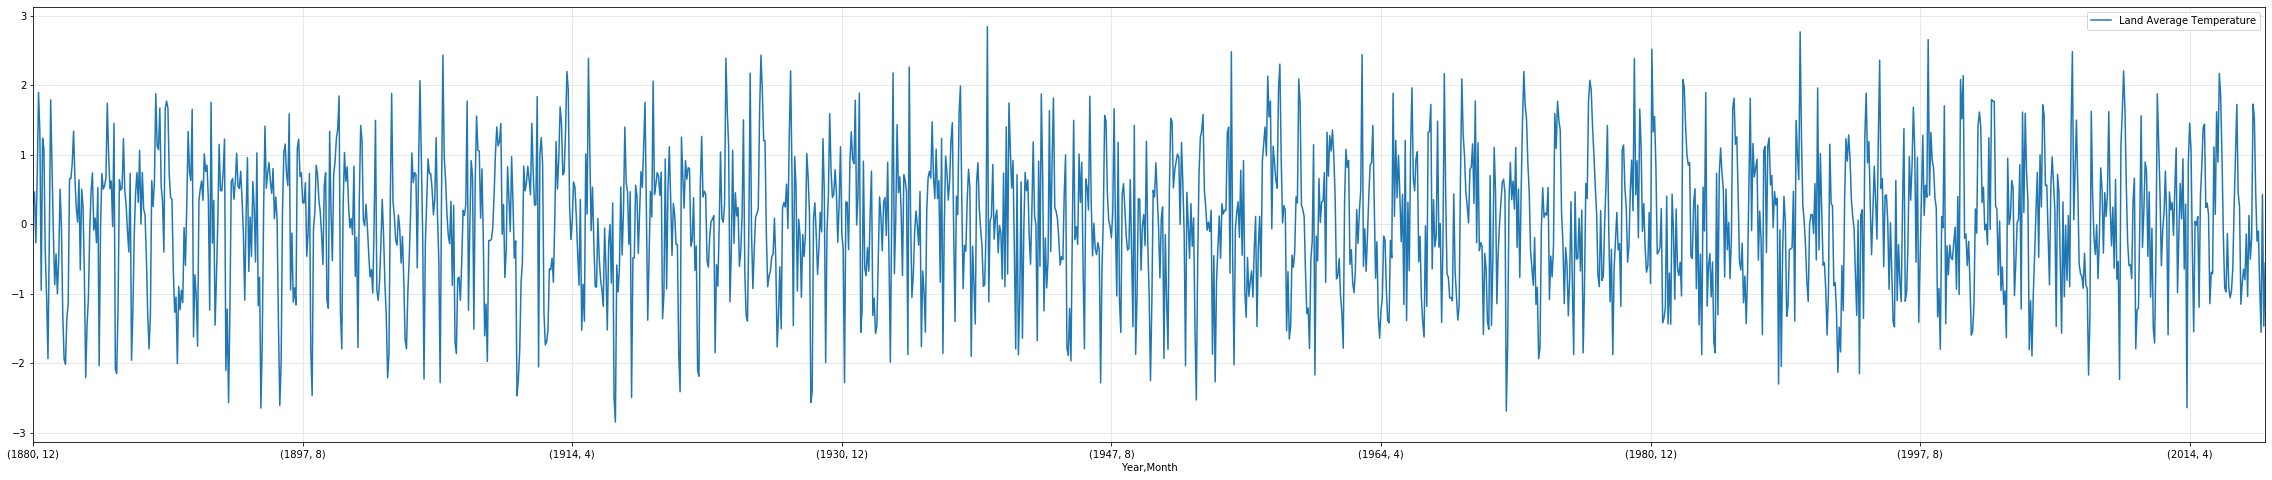

In [21]:
df = df_z.dropna()
fig, ax = plt.subplots()
# df = df.set_index('date')
df.plot(y='z_Temperature', label='Land Average Temperature', figsize = (40,8), ax=ax)
ax.grid(color='lightgray', linestyle='-', linewidth=.5)

In [22]:
adf_test(df_z.z_Temperature.dropna())

Result of Dickey-Fuller Test:
Test statistic = -9.384
P-value = 0.000
Critical values:
	1%: -3.434363244707632 - The data is stationary with 99% confidence
	5%: -2.8633126160514863 - The data is stationary with 95% confidence
	10%: -2.567713701716287 - The data is stationary with 90% confidence


**12 lag differenced de-trended data - rolling mean (annual)**

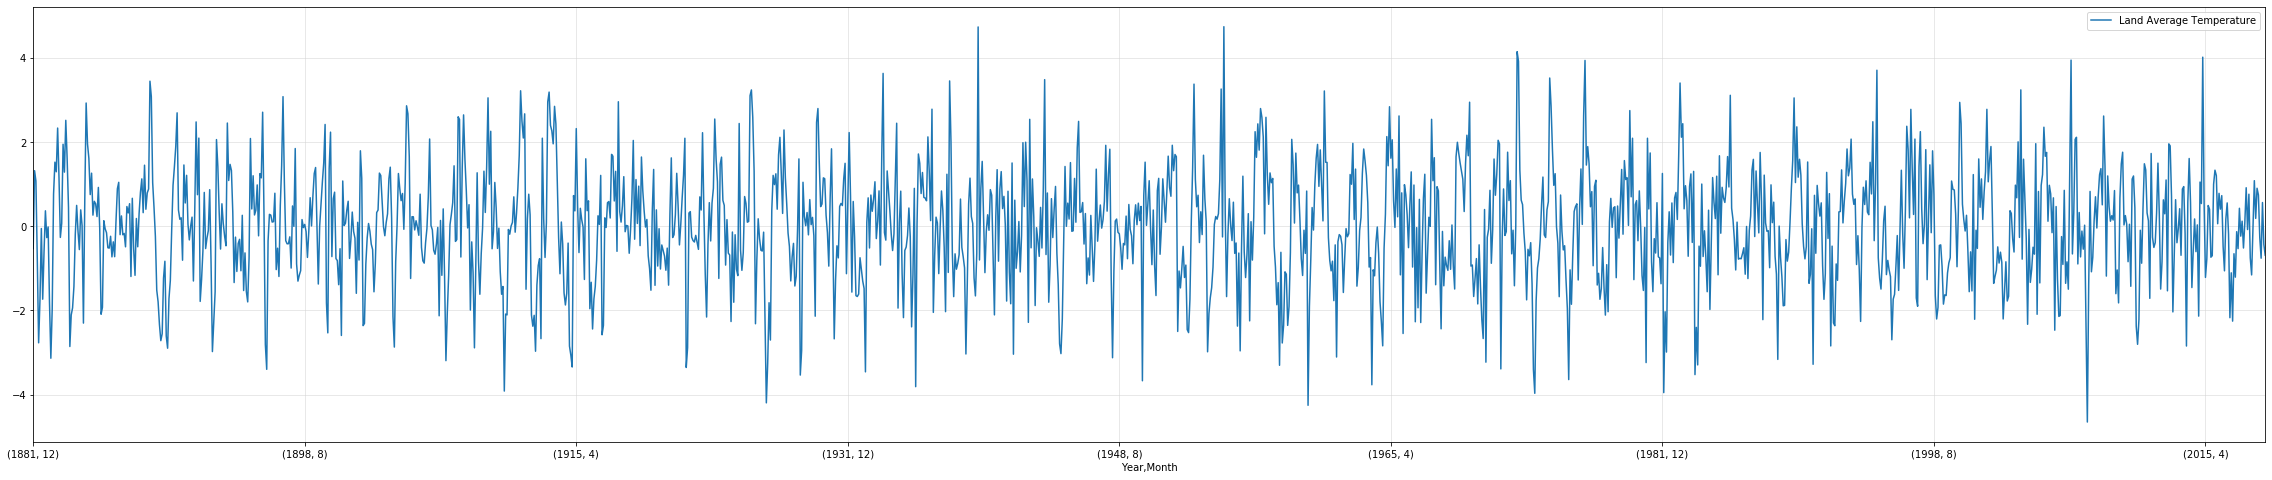

In [23]:
df = df_zp.dropna()
# df = df.set_index('date')
fig, ax = plt.subplots()
df.plot(y='zp_Temperature', label='Land Average Temperature', figsize = (40,8), ax=ax)
ax.grid(color='lightgray', linestyle='-', linewidth=.5)

In [24]:
adf_test(df_zp.zp_Temperature.dropna())

Result of Dickey-Fuller Test:
Test statistic = -13.095
P-value = 0.000
Critical values:
	1%: -3.4343930197503107 - The data is stationary with 99% confidence
	5%: -2.8633257585414 - The data is stationary with 95% confidence
	10%: -2.567720699969517 - The data is stationary with 90% confidence


## Data Analysis

### ACF/PACF charts 

Use ACF/PACF charts and domain knowledge to tune the ARIMA model’s parameters

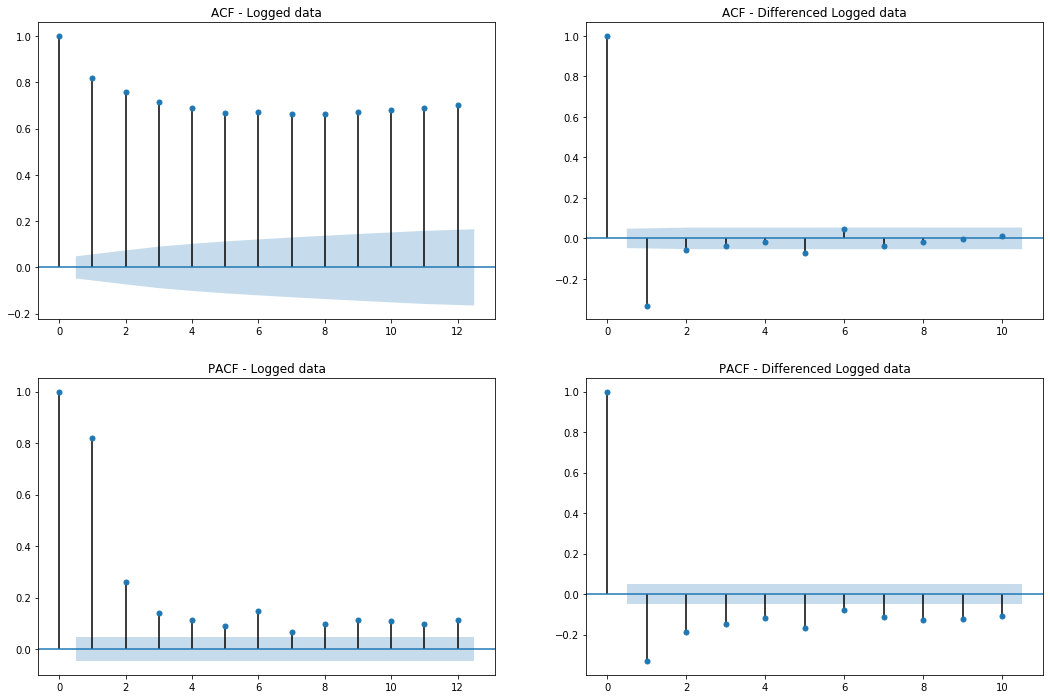

In [25]:
# df = TAVG_df.loc[(TAVG_df['Day of Year']==1)].copy()
df = TAVG_df.groupby([TAVG_df['Year'],TAVG_df['Month']])['Temperature'].mean().to_frame().copy()
fig, ax = plt.subplots(2, 2, figsize=(18, 12))
first_diff = (np.log(df.Temperature) - np.log(df.Temperature).shift()).dropna()
ax[0,0] = plot_acf(np.log(df.Temperature), ax = ax[0,0], lags = 12, title = "ACF - Logged data")
ax[0,1] = plot_acf(first_diff , ax=ax[0, 1], lags=10, title="ACF - Differenced Logged data")

ax[1,0] = plot_pacf(np.log(df.Temperature), ax = ax[1,0], lags = 12, title = "PACF - Logged data")
ax[1,1] = plot_pacf(first_diff, ax=ax[1, 1], lags=10, title="PACF - Differenced Logged data")

### Fit an ARIMA model to the data

An **ARIMA model** is a class of statistical models for analyzing and forecasting time series data.

It explicitly caters to a suite of standard structures in time series data, and as such provides a simple yet powerful method for making skillful time series forecasts.

ARIMA is an acronym that stands for AutoRegressive Integrated Moving Average. It is a generalization of the simpler AutoRegressive Moving Average and adds the notion of integration.

This acronmy is descriptive, capturing the key aspects of the model itself. Briefly, they are:

- **AR**: Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations.


- **I**: Integrated. The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.


- **MA**: Moving Average. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.

Each of these components are explicitly specified in the model as a parameter. A standard notation is used of ARIMA(p,d,q) where the parameters are substituted with integer values to quickly indicate the specific ARIMA model being used.

The parameters of the ARIMA model are defined as follows:

- **p**: The number of lag observations included in the model, also called the lag order.


- **d**: The number of times that the raw observations are differenced, also called the degree of differencing.


- **q**: The size of the moving average window, also called the order of moving average.

**ARIMA**

In [26]:
df = TAVG_df.groupby([TAVG_df['Year'],TAVG_df['Month']])['Temperature'].mean().to_frame().copy()
model = ARIMA(np.log(df.Temperature).dropna(), (0,0,0))
res_000 = model.fit()
print(res_000.summary())

model = ARIMA(np.log(df.Temperature).dropna(), (0,1,0))
res_010 = model.fit()
print(res_010.summary())

                              ARMA Model Results                              
Dep. Variable:            Temperature   No. Observations:                 1668
Model:                     ARMA(0, 0)   Log Likelihood                2116.535
Method:                           css   S.D. of innovations              0.068
Date:                Tue, 11 Feb 2020   AIC                          -4229.071
Time:                        13:12:24   BIC                          -4218.232
Sample:                             0   HQIC                         -4225.054
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.1562      0.002   1294.516      0.000       2.153       2.159
                             ARIMA Model Results                              
Dep. Variable:          D.Temperature   No. Observat

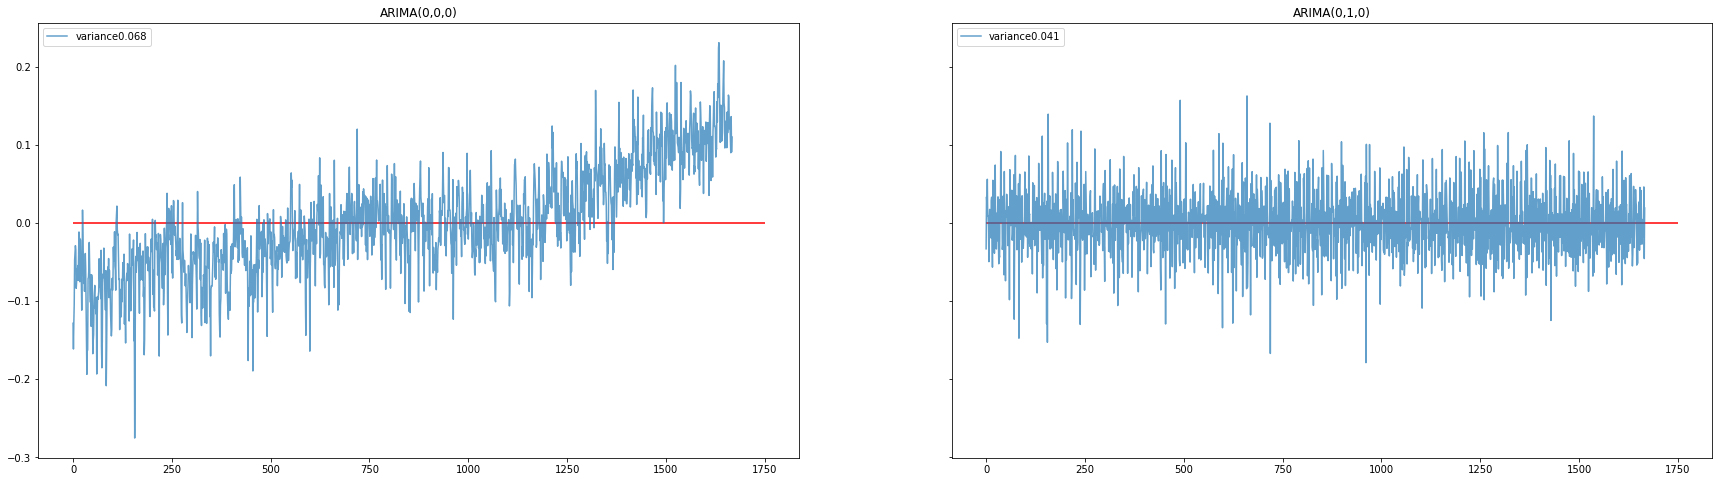

In [27]:
fig, ax = plt.subplots(1, 2, sharey = True, figsize=(30,8))
ax[0].plot(res_000.resid.values, alpha=0.7, label='variance{:.3f}'.format(np.std(res_000.resid.values)))
ax[0].hlines(0, xmin=0, xmax=1750, color='r')
ax[0].set_title("ARIMA(0,0,0)")
ax[0].legend(loc='upper left')

ax[1].plot(res_010.resid.values, alpha=0.7, label='variance{:.3f}'.format(np.std(res_010.resid.values)))
ax[1].hlines(0, xmin=0, xmax=1750, color='r')
ax[1].set_title("ARIMA(0,1,0)")
ax[1].legend(loc='upper left')

**Find the best p, d, q**

AIC is essentially a tool to aid in model selection. That is, if we have a selection of statistical models (including time series), then the AIC estimates the "quality" of each model, relative to the others that we have available.

The preferred model, from a selection of models, has the minium AIC of the group. 

In [28]:
df = TAVG_df.groupby([TAVG_df['Year'],TAVG_df['Month']])['Temperature'].mean().to_frame().copy()
best_aic = np.inf 
best_order = None
best_mdl = None

rng = range(3)
for p in rng:
    for d in rng:
        for q in rng:
            try:
                tmp_mdl = ARIMA(np.log(df.Temperature).dropna(), (p,d,q))
                tmp_mdl = tmp_mdl.fit()
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (p, d, q)
                    best_mdl = tmp_mdl
            except: continue



print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

aic: -6438.51082 | order: (2, 1, 1)


In [29]:
df = TAVG_df.groupby([TAVG_df['Year'],TAVG_df['Month']])['Temperature'].mean().to_frame().copy()
model = ARIMA(np.log(df.Temperature).dropna(), (2,1,1))
res_211 = model.fit()
print(res_211.summary())

                             ARIMA Model Results                              
Dep. Variable:          D.Temperature   No. Observations:                 1667
Model:                 ARIMA(2, 1, 1)   Log Likelihood                3224.255
Method:                       css-mle   S.D. of innovations              0.035
Date:                Tue, 11 Feb 2020   AIC                          -6438.511
Time:                        13:12:35   BIC                          -6411.417
Sample:                             1   HQIC                         -6428.471
                                                                              
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0001   3.47e-05      3.668      0.000    5.93e-05       0.000
ar.L1.D.Temperature     0.4177      0.025     16.697      0.000       0.369       0.467
ar.L2.D.Temperat

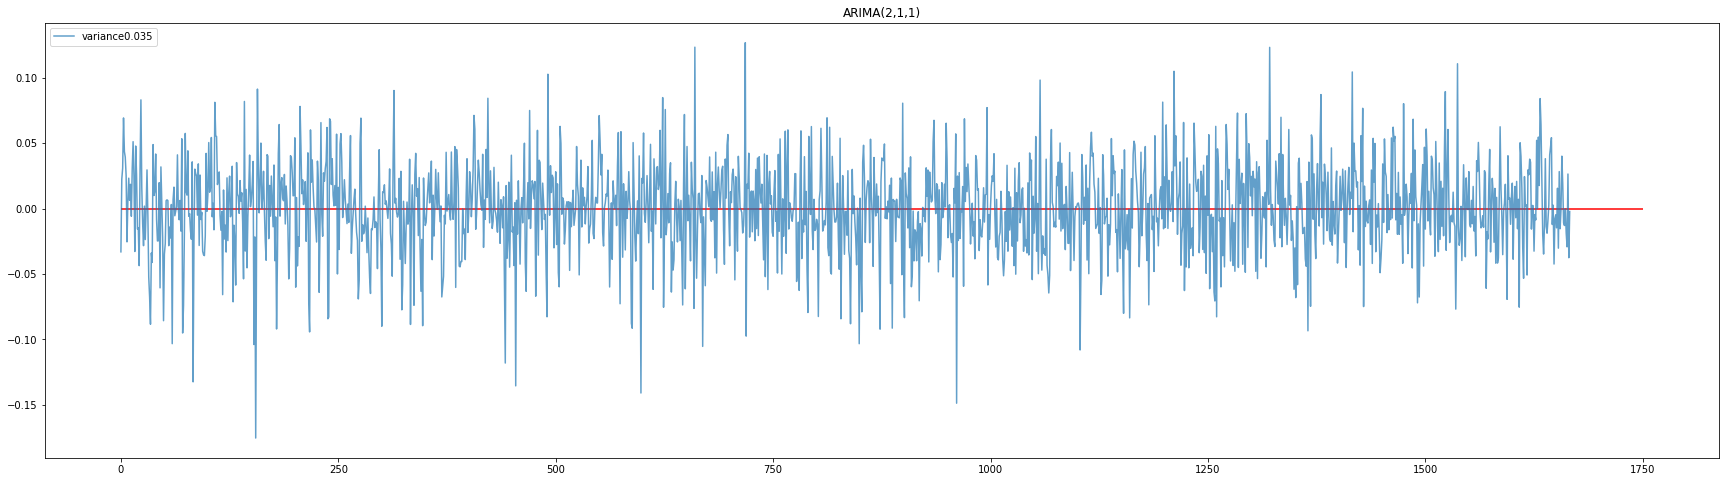

In [30]:
fig, ax = plt.subplots(sharey = True, figsize=(30,8))
ax.plot(res_211.resid.values, alpha=0.7, label='variance{:.3f}'.format(np.std(res_211.resid.values)))
ax.hlines(0, xmin=0, xmax=1750, color='r')
ax.set_title("ARIMA(2,1,1)")
ax.legend(loc='upper left')

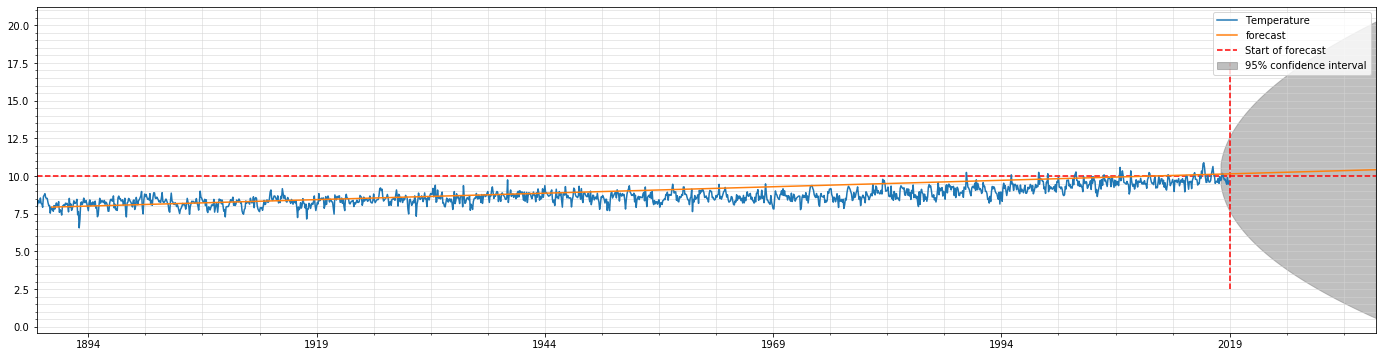

In [31]:
df = TAVG_df.groupby([TAVG_df['Year'],TAVG_df['Month']])['Temperature'].mean().to_frame().copy()
df.index = pd.to_datetime(df.index.get_level_values(0).astype(str) + '-' +
               df.index.get_level_values(1).astype(str),
               format='%Y-%m').strftime('%Y-%m')
model = ARIMA(df.Temperature.dropna()[:-12],(0,1,0))
res_010 = model.fit()

fig, ax = plt.subplots(figsize=(24, 6));
df.index = pd.to_datetime(df.index, format = "%Y-%m")
df.Temperature[100:].dropna().plot(ax=ax)
ax.vlines('2019-01', 2.5, 17.5, linestyle='--', color='r', label="Start of forecast")
res_010.plot_predict(start = '1890-01', end = '2035-01', dynamic=True, plot_insample=False, ax=ax)
ax.grid(color='lightgray', linestyle='-', linewidth=.5, which='both')
ax.hlines(10,ax.get_xlim()[0], ax.get_xlim()[1], linestyle='--', color='r', label="Temperature = 10")
plt.minorticks_on()

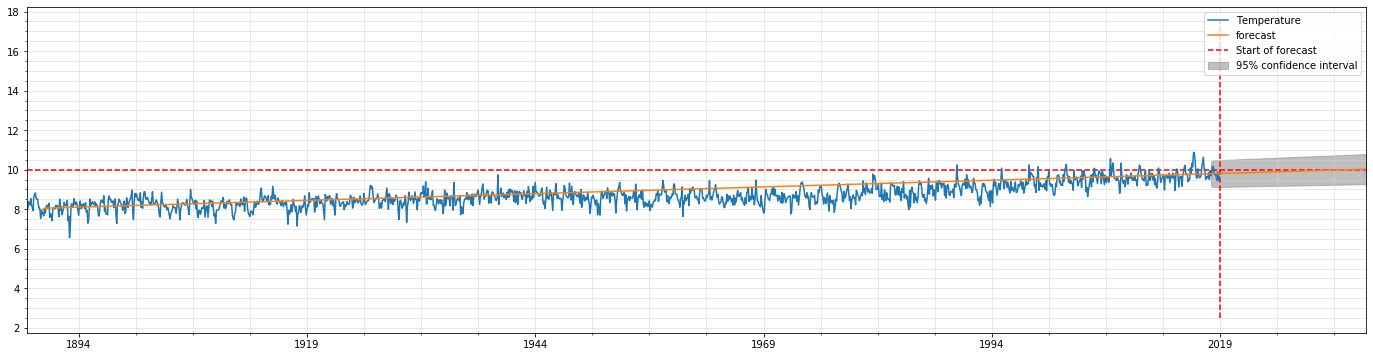

In [32]:
df = TAVG_df.groupby([TAVG_df['Year'],TAVG_df['Month']])['Temperature'].mean().to_frame().copy()
df.index = pd.to_datetime(df.index.get_level_values(0).astype(str) + '-' +
               df.index.get_level_values(1).astype(str),
               format='%Y-%m').strftime('%Y-%m')
model = ARIMA(df.Temperature.dropna()[:-12],(2,1,1))
res_211 = model.fit()

fig, ax = plt.subplots(figsize=(24, 6));
df.index = pd.to_datetime(df.index, format = "%Y-%m")
df.Temperature[100:].dropna().plot(ax=ax)
ax.vlines('2019-01', 2.5, 17.5, linestyle='--', color='r', label="Start of forecast")
res_211.plot_predict(start = '1890-01', end = '2035-01', dynamic=True, plot_insample=False, ax=ax)
ax.grid(color='lightgray', linestyle='-', linewidth=.5, which='both')
ax.hlines(10,ax.get_xlim()[0], ax.get_xlim()[1], linestyle='--', color='r', label="Temperature = 10")
plt.minorticks_on()

**Evaluate the model**

In [33]:
df_pred = res_211.predict(start = '2000-01', end = '2035-01', dynamic=True, typ='levels')

df_forecasted = df_pred['2000-01':'2018-12']
df_truth = df['2000':]

# Compute the mean square error
mse = ((df_forecasted - df_truth.Temperature) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 0.16


In [34]:
print("The temperature in 2035-01 will be %.3f"%df_pred[-1])

The temperature in 2035-01 will be 9.752


**SARIMA**

In [45]:
df = TAVG_df.groupby([TAVG_df['Year'],TAVG_df['Month']])['Temperature'].mean().to_frame().copy()
df.index = pd.to_datetime(df.index.get_level_values(0).astype(str) + '-' +
               df.index.get_level_values(1).astype(str),
               format='%Y-%m').strftime('%Y-%m')
model = SARIMAX(df.Temperature.dropna(), order=(1,1,1), seasonal_order=(1,1,1,12),
                enforce_stationarity=False,
                enforce_invertibility=False)
res_211 = model.fit()
print(res_211.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3937      0.023     16.790      0.000       0.348       0.440
ma.L1         -0.9544      0.009   -101.309      0.000      -0.973      -0.936
ar.S.L12      -0.0447      0.022     -2.000      0.046      -0.089      -0.001
ma.S.L12      -0.9495      0.008   -113.216      0.000      -0.966      -0.933
sigma2         0.0825      0.002     35.615      0.000       0.078       0.087


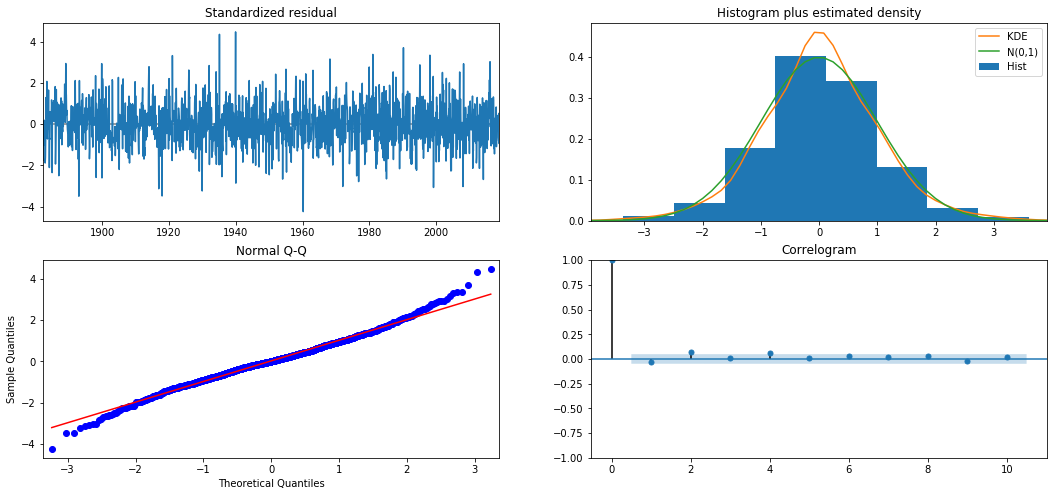

In [46]:
res_211.plot_diagnostics(figsize=(18, 8))
plt.show()

With the diagnostic above we can visualize important information as the distribution and the Auto correlation function ACF (correlogram). Values upward the “0” has some correlation over the time series data. Values near to “1” demonstrates strongest correlation.

In [47]:
pred = res_211.get_prediction(start=pd.to_datetime('2000-01'),end=pd.to_datetime('2035-01'), dynamic=False)
pred_ci = pred.conf_int()
df_pred = pred.predicted_mean.to_frame()
df_pred.index = pd.to_datetime(df_pred.index, format='%Y-%m').strftime('%Y-%m')
df_pred = df_pred.rename(columns={0:'Forecast'})

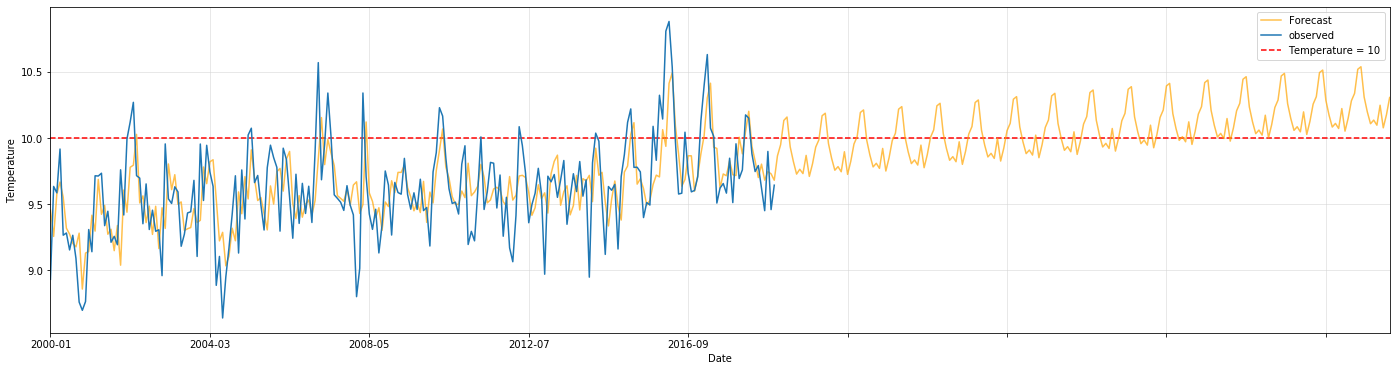

In [48]:
fig, ax = plt.subplots(figsize=(24, 6))
df_pred.plot(ax=ax, label = 'Forecast', alpha = .7, color = 'orange')
df['2000':].Temperature.plot(label='observed', figsize=(24, 6), ax=ax)
ax.set_xlabel('Date')
ax.set_ylabel('Temperature')
ax.grid(color='lightgray', linestyle='-', linewidth=.5, which='both')
ax.hlines(10,ax.get_xlim()[0], ax.get_xlim()[1], linestyle='--', color='r', label="Temperature = 10")
plt.legend()

**Evaluate SARIMA**

In [49]:
df_forecasted = df_pred['2000-01':'2018-12']
df_truth = df['2000':]

# Compute the mean square error
mse = ((df_forecasted.Forecast - df_truth.Temperature) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 0.08


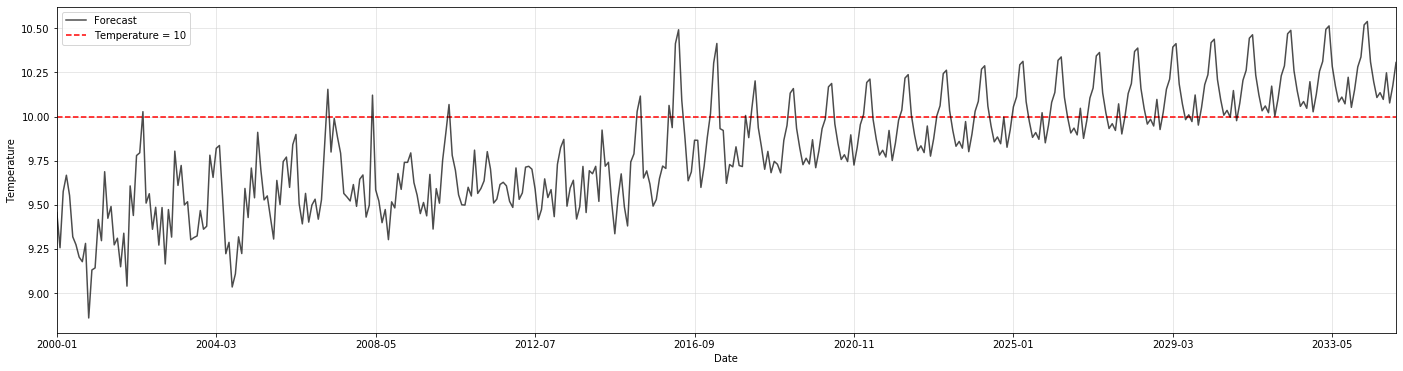

In [50]:
fig, ax = plt.subplots(figsize=(24, 6))
df_pred.plot(ax=ax, label = 'Forecast', alpha = .7,color='black')
ax.grid(color='lightgray', linestyle='-', linewidth=.5, which='both')
ax.hlines(10,ax.get_xlim()[0], ax.get_xlim()[1], linestyle='--', color='r', label="Temperature = 10")
ax.set_xlabel('Date')
ax.set_ylabel('Temperature')
plt.legend()

In [41]:
print("The temperature in 2035-01 will be %.3f"%df_pred.Forecast[-1])

The temperature in 2035-01 will be 10.306


In [51]:
df = TAVG_df.groupby([TAVG_df['Year'],TAVG_df['Month']])['Temperature'].mean().to_frame().copy()
df.index = pd.to_datetime(df.index.get_level_values(0).astype(str) + '-' +
               df.index.get_level_values(1).astype(str),
               format='%Y-%m').strftime('%Y-%m')

In [52]:
df.iloc[-1]

Temperature    9.643806
Name: 2018-12, dtype: float64

In [53]:
df.iloc[0]

Temperature    7.597355
Name: 1880-01, dtype: float64

### Findings:

- AIC is helpful in parameter selection.


- According to the mean square error, the SARIMA algorithm(0.08) performance better than ARIMA algorithm(0.16).

**What is global warming?**

Human activities have increased carbon-dioxide emissions, driving up temperatures. 

The effects of global warming are being felt globally. In recent years, extreme heat waves have caused thousands of deaths worldwide. And since 2002, Antarctica has lost about 134 billion tons of ice every year, which is a shocking sign. Some experts say that if we continue to burn fossil fuels at the current rate, this rate may accelerate, leading to rising sea levels. Rise a few meters over the next 50 to 150 years.

From our analysis, the temperature is rising. We predict in 2035-01, the land temperature will be 10.306, up 0.7 degree than 2018-12, and 2.77 than 1880-01.


**What can we do about global warming?**

1. Increase the energy efficiency of our cars, homes, and power plants while lowering our consumption by adjusting our thermostats and traveling fewer miles;


2. Capture the carbon emitted by power plants and store it underground;


3. Produce more energy from nuclear, natural gas, and renewable fuels—solar, wind, hydroelectric, and bio-fuels;


4. Halt deforestation and soil degradation worldwide, while reforesting more areas.

# References
[1] http://berkeleyearth.org/data/

[2] Prakash,K,.&Pal,A(2017). Practical Time Series Analysis. Packt Publishing.
